In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy import units as u
from astropy.io import ascii
from astroquery.xmatch import XMatch
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord, ICRS, Galactic, Angle
from astropy.time import Time
from tqdm import tqdm

In [2]:
files = glob.glob('../IPTA_DR1/*/*.par')

In [63]:
def hist_weight(lst):
    return np.ones_like(lst)/len(lst)

def auto_bin(bin_size, min_edge, max_edge):
    #bin_size = 0.05; min_edge = -3.5; max_edge = -1
    N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
    bin_list = np.linspace(min_edge, max_edge, Nplus1)
    return bin_list

In [3]:
RAs = []
DECs = []
Names = []
pmra = []
pmra_err = []
pmdec = []
pmdec_err = []
pepoch = []
posepoch = []
dmepoch = []
dm = []
coords = []

In [4]:
for file in files:
    d = {}
    with open(file) as f:
        for line in f:
            key = line.split()[0]
            value = line.split()[1]
            d[key] = value
            if key in ['RAJ', 'DECJ', 'PMRA', 'PMDEC', 'PX']:
                try:
                    err = line.split()[3]
                    d[key+'_ERR'] = err
                except:
                    print("this file is missing uncertainties \
on {0}: {1}".format(key, file))
                    d[key+'_ERR'] = 0.0
    
    try:
        ra = Angle(d['RAJ'], u.hourangle).to(u.deg)
        dec = Angle(d['DECJ'], u.degree)
        coord = SkyCoord(ra=ra, dec=dec, frame='icrs',
                         pm_ra_cosdec = float(d['PMRA'])*u.mas/u.yr,
                         pm_dec=float(d['PMDEC'])*u.mas/u.yr,
                         obstime=Time(float(d['POSEPOCH']), format='mjd'),
                         distance=1. * u.kpc) # HACK
        coords.append(coord)
        RAs.append(ra.value)
        DECs.append(dec.value)
        Names.append(d['PSRJ'])
        pmra.append(coord.pm_ra_cosdec.value)
        pmra_err.append(float(d['PMRA_ERR']))
        pmdec.append(coord.pm_dec.value)
        pmdec_err.append(float(d['PMDEC_ERR']))
        pepoch.append(d['PEPOCH'])
        posepoch.append(d['POSEPOCH'])
        dmepoch.append(d['DMEPOCH'])
        dm.append(d['DM'])
        
    except KeyError:
        lon = float(d['ELONG'])*u.deg
        lat = float(d['ELAT'])*u.deg
        coord = SkyCoord(l=lon, b=lat, frame='galactic',
                             pm_l_cosb = float(d['PMELONG'])*u.mas/u.yr, 
                             pm_b=float(d['PMELAT'])*u.mas/u.yr,
                             obstime=Time(float(d['POSEPOCH']), format='mjd'),
                             distance=1. * u.kpc) # HACKITY HACK HACK
        icrscoord = coord.transform_to(ICRS)
        coords.append(icrscoord)
        print("this object has galactic coords: {0}".format(d['PSRJ']))
        RAs.append(icrscoord.ra.to(u.deg).value)
        DECs.append(icrscoord.dec.to(u.deg).value)
        Names.append(d['PSRJ'])
        pmra.append(icrscoord.pm_ra_cosdec.value)
        pmra_err.append(0.0) # TEMPORARY HACK
        pmdec.append(icrscoord.pm_dec.value)
        pmdec_err.append(0.0) # TEMPORARY HACK
        pepoch.append(d['PEPOCH'])
        posepoch.append(d['POSEPOCH'])
        dmepoch.append(d['DMEPOCH'])
        dm.append(d['DM']) 

this file is missing uncertainties on RAJ: ../IPTA_DR1/J0437-4715/J0437-4715.par
this file is missing uncertainties on DECJ: ../IPTA_DR1/J0437-4715/J0437-4715.par
this file is missing uncertainties on PMRA: ../IPTA_DR1/J0437-4715/J0437-4715.par
this file is missing uncertainties on PMDEC: ../IPTA_DR1/J0437-4715/J0437-4715.par
this file is missing uncertainties on PX: ../IPTA_DR1/J0437-4715/J0437-4715.par
this object has galactic coords: J1022+1001
this file is missing uncertainties on RAJ: ../IPTA_DR1/J1643-1224/J1643-1224.par
this file is missing uncertainties on DECJ: ../IPTA_DR1/J1643-1224/J1643-1224.par
this file is missing uncertainties on PMRA: ../IPTA_DR1/J1643-1224/J1643-1224.par
this file is missing uncertainties on PMDEC: ../IPTA_DR1/J1643-1224/J1643-1224.par
this file is missing uncertainties on PX: ../IPTA_DR1/J1643-1224/J1643-1224.par


In [27]:
Names

['J0030+0451',
 'J0034-0534',
 'J0218+4232',
 'J0437-4715',
 'J0610-2100',
 'J0613-0200',
 'J0621+1002',
 'J0711-6830',
 'J0751+1807',
 'J0900-3144',
 'J1012+5307',
 'J1022+1001',
 'J1024-0719',
 'J1045-4509',
 'J1455-3330',
 'J1600-3053',
 'J1603-7202',
 'J1640+2224',
 'J1643-1224',
 'J1713+0747',
 'J1721-2457',
 'J1730-2304',
 'J1732-5049',
 'J1738+0333',
 'J1744-1134',
 'J1751-2857',
 'J1801-1417',
 'J1802-2124',
 'J1804-2717',
 'J1824-2452A',
 'J1843-1113',
 'J1853+1303',
 'J1857+0943',
 'J1909-3744',
 'J1910+1256',
 'J1911+1347',
 'J1911-1114',
 'J1918-0642',
 'J1939+2134',
 'J1955+2908',
 'J2010-1323',
 'J2019+2425',
 'J2033+1734',
 'J2124-3358',
 'J2129-5721',
 'J2145-0750',
 'J2229+2643',
 'J2317+1439',
 'J2322+2057']

### a bad case: J1910+1256

In [5]:
ind = np.where(np.array(Names) == 'J1910+1256')[0][0]

In [6]:
ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

In [7]:
ipta_coord = coords[ind]
ipta_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (287.54042259, 12.9404131, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (0.25061013, -6.93472136)>

In [8]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=287.5407215 * u.degree, 
                             dec=12.94037301 * u.degree, frame='icrs',
                         pm_ra_cosdec = -0.672057539 *u.mas/u.yr,
                         pm_dec= -5.449112763 *u.mas/u.yr,
                         obstime=Time(2015.5, format='decimalyear'),
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 0.576369178
gaia_dec_err = 0.623526292
gaia_match_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (287.5407215, 12.94037301, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-0.67205754, -5.44911276)>

In [9]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

1.0526847597792082

In [41]:
N = 500
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

100%|██████████| 500/500 [00:59<00:00,  8.40it/s]


In [42]:
np.min(ipta_ras)

69.31657691151423

In [43]:
np.std(gaia_ras)

0.00015911494445403624

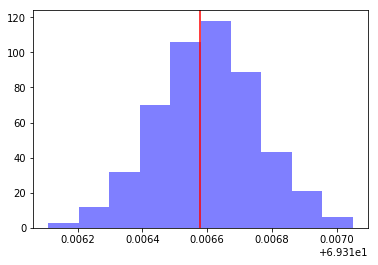

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(gaia_ras, alpha=0.5, color='blue')
plt.axvline(np.median(ipta_ras), color='red')

#ax.hist(ipta_ras, alpha=0.5, color='red')
#ax.set_xlim([np.min(ipta_ras),np.max(ipta_ras)+0.00001])

(-47.252668392775306, -47.25266745815621)

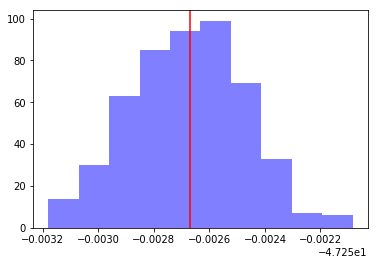

In [45]:
#plt.hist(ipta_decs, alpha=0.5, color='red')
plt.axvline(np.median(ipta_decs), color='red')
plt.hist(gaia_decs, alpha=0.5, color='blue')
ax.set_xlim([np.min(ipta_decs),np.max(ipta_decs)])

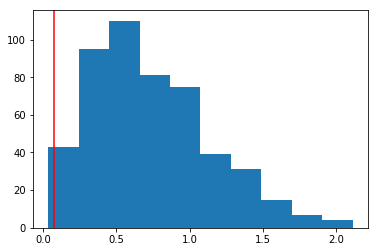

In [46]:
plt.hist(seps)
plt.axvline(gaia_ipta_sep, c='red')

## a not-so-bad disagreement case: J1012+5307

In [47]:
ind = np.where(np.array(Names) == 'J1012+5307')[0][0]

In [48]:
ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

In [49]:
ipta_coord = coords[ind]
ipta_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (153.13932304, 53.1173056, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (2.62371226, -25.45880892)>

In [50]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=153.1393303 * u.degree, 
                             dec=53.11726303 * u.degree, frame='icrs',
                         pm_ra_cosdec = 2.976959985 *u.mas/u.yr,
                         pm_dec= -26.94384758 *u.mas/u.yr,
                         obstime= gaia_time,
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 0.241174616
gaia_dec_err = 0.302546482
gaia_match_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (153.1393303, 53.11726303, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (2.97695999, -26.94384758)>

In [51]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

0.012298049411488533

In [52]:
N = 500
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

100%|██████████| 500/500 [00:45<00:00, 10.87it/s]


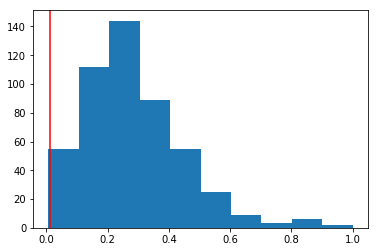

In [54]:
plt.hist(seps)
plt.axvline(gaia_ipta_sep, c='red')

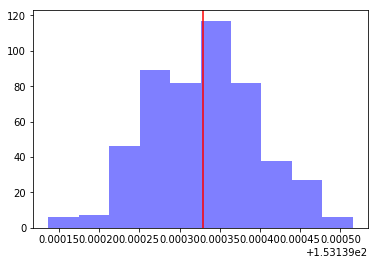

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(gaia_ras, alpha=0.5, color='blue')
plt.axvline(np.median(ipta_ras), color='red')

#ax.hist(ipta_ras, alpha=0.5, color='red')
#ax.set_xlim([np.min(ipta_ras),np.max(ipta_ras)+0.00001])

(53.117266316699315, 53.11726653964263)

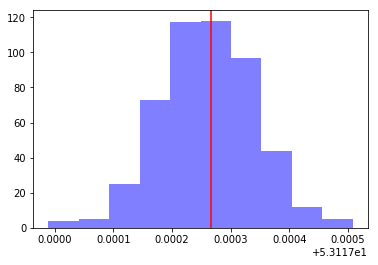

In [56]:
#plt.hist(ipta_decs, alpha=0.5, color='red')
plt.axvline(np.median(ipta_decs), color='red')
plt.hist(gaia_decs, alpha=0.5, color='blue')
ax.set_xlim([np.min(ipta_decs),np.max(ipta_decs)])

## Best pulasr, J0437-4715


In [28]:
ind = np.where(np.array(Names) == 'J0437-4715')[0][0]

In [30]:
ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

In [33]:
ipta_pmra_err = 0.052 #Deller et al. 2008, Table 1
ipta_pmdec_err = 0.086 #Deller et al. 2008
ipta_posepoch = posepoch[ind]


In [34]:
ipta_coord = coords[ind]
ipta_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (69.31623406, -47.25253075, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (121.43993282, -71.47620158)>

In [35]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=69.31660276 * u.degree, 
                             dec=-47.25267778 * u.degree, frame='icrs',
                         pm_ra_cosdec = 122.8637296 *u.mas/u.yr,
                         pm_dec= -71.16597382 *u.mas/u.yr,
                         obstime=Time(2015.5, format='decimalyear'),
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 0.582326756
gaia_dec_err = 0.738504992
gaia_match_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (69.31660276, -47.25267778, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (122.8637296, -71.16597382)>

In [36]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

0.07154597070179823

In [59]:
N = 500
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

100%|██████████| 500/500 [00:45<00:00, 11.02it/s]


In [134]:
bin_list = auto_bin(.08,-0.01,1)
weights = hist_weight(seps)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


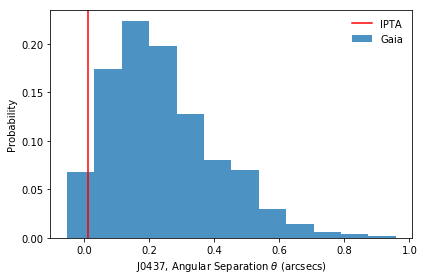

In [136]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(seps, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(gaia_ipta_sep, color='red', label = "IPTA")
plt.xlabel(r"J0437, Angular Separation $\theta$ (arcsecs)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J0437_Theta_IPTA-GAIA.pdf")



In [138]:
bin_list = auto_bin(.00004,153.13905,153.13954)
weights = hist_weight(gaia_ras)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


In [139]:
min(gaia_ras)

153.13907208337713

In [140]:
max(gaia_ras)

153.1395202226001

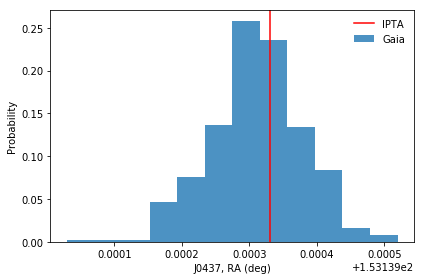

In [142]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(gaia_ras, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_ras), color='red', label = "IPTA")
plt.xlabel("J0437, RA (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J0437_RA_IPTA-GAIA.pdf")

In [144]:
bin_list = auto_bin(.00005,53.1168,53.1177)
weights = hist_weight(gaia_decs)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


In [145]:
max(gaia_decs)

53.11751571887467

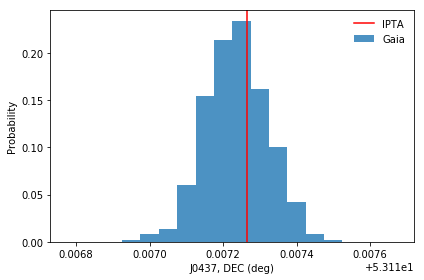

In [147]:
# DEC plot for J0437
plt.hist(gaia_decs, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_decs), color='red', label = "IPTA")
ax.set_xlim([np.min(ipta_decs),np.max(ipta_decs)])
plt.xlabel("J0437, DEC (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J0437_DEC_IPTA-GAIA.pdf")

## Pulsar J1024-0719

In [149]:
ind = np.where(np.array(Names) == 'J1024-0719')[0][0]

ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]


ipta_coord = coords[ind]
ipta_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (156.16114741, -7.32206499, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-35.3049269, -48.24394017)>

In [150]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=156.1610927 * u.degree, 
                             dec=-7.322165289 * u.degree, frame='icrs',
                         pm_ra_cosdec = -35.51929892*u.mas/u.yr,
                         pm_dec= -47.93231066 *u.mas/u.yr,
                         obstime=Time(2015.5, format='decimalyear'),
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 0.42985265
gaia_dec_err = 0.392656637
gaia_match_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (156.1610927, -7.32216529, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-35.51929892, -47.93231066)>

In [151]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

0.09388321101894358

In [152]:
N = 500
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

100%|██████████| 500/500 [01:00<00:00,  8.25it/s]


In [159]:
bin_list = auto_bin(.08,0.0,1.8)
weights = hist_weight(seps)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


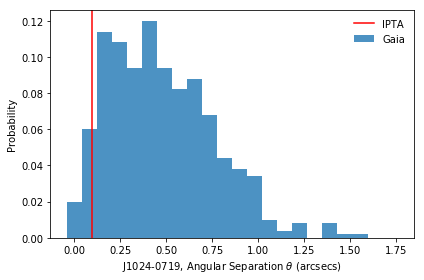

In [160]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(seps, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(gaia_ipta_sep, color='red', label = "IPTA")
plt.xlabel(r"J1024-0719, Angular Separation $\theta$ (arcsecs)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1024_Theta_IPTA-GAIA.pdf")

In [166]:
bin_list = auto_bin(.00004,156.16068395,156.16149774)
weights = hist_weight(gaia_ras)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


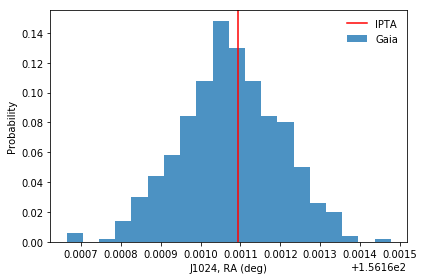

In [167]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(gaia_ras, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_ras), color='red', label = "IPTA")
plt.xlabel("J1024, RA (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1024_RA_IPTA-GAIA.pdf")

In [ ]:
# DEC plot for J1024
plt.hist(gaia_decs, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_decs), color='red', label = "IPTA")
ax.set_xlim([np.min(ipta_decs),np.max(ipta_decs)])
plt.xlabel("J1024-0719, DEC (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1024_DEC_IPTA-GAIA.pdf")

## not so great pulsar J1732-5049

In [169]:
ind = np.where(np.array(Names) == 'J1732-5049')[0][0]

ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]


ipta_coord = coords[ind]
ipta_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (263.19902801, -50.81671992, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-0.4321012, -9.90996085)>

In [170]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=263.200006 * u.degree, 
                             dec=-50.8166163 * u.degree, frame='icrs',
                         pm_ra_cosdec = -0.031849016*u.mas/u.yr,
                         pm_dec= -10.483062*u.mas/u.yr,
                         obstime=Time(2015.5, format='decimalyear'),
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 2.168898313
gaia_dec_err = 2.010098257
gaia_match_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (263.200006, -50.8166163, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-0.03184902, -10.483062)>

In [171]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

2.270753721341421

In [172]:
N = 500
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

100%|██████████| 500/500 [00:58<00:00,  8.51it/s]


In [185]:
bin_list = auto_bin(.5,0.0,8.0)
weights = hist_weight(seps)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


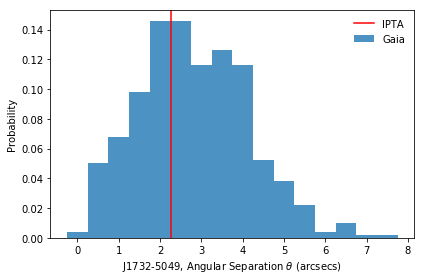

In [186]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(seps, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(gaia_ipta_sep, color='red', label = "IPTA")
plt.xlabel(r"J1732-5049, Angular Separation $\theta$ (arcsecs)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1732_Theta_IPTA-GAIA.pdf")

In [196]:
bin_list = auto_bin(.0002,263.1979,263.20179)
weights = hist_weight(gaia_ras)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


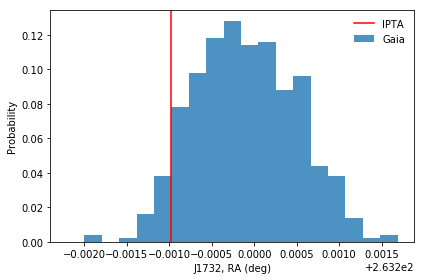

In [197]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(gaia_ras, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_ras), color='red', label = "IPTA")
plt.xlabel("J1732, RA (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1024_RA_IPTA-GAIA.pdf")



In [209]:
bin_list = auto_bin(.0002,-50.8180,-50.81478)
weights = hist_weight(gaia_decs)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


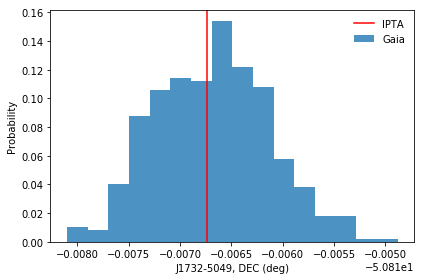

In [214]:
# DEC plot for J1732
plt.hist(gaia_decs, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_decs), color='red', label = "IPTA")
ax.set_xlim([np.min(ipta_decs),np.max(ipta_decs)])
plt.xlabel("J1732-5049, DEC (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1732_DEC_IPTA-GAIA.pdf")

## Pulsar J1955+2908

In [217]:
ind = np.where(np.array(Names) == 'J1955+2908')[0][0]

ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]


ipta_coord = coords[ind]
ipta_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (298.86614892, 29.14540536, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-0.81162453, -4.06546809)>

In [218]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=298.8661015 * u.degree, 
                             dec=29.14538275 * u.degree, frame='icrs',
                         pm_ra_cosdec = -3.092116051*u.mas/u.yr,
                         pm_dec= -7.962991888*u.mas/u.yr,
                         obstime=Time(2015.5, format='decimalyear'),
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 0.125519342
gaia_dec_err = 0.165511548
gaia_match_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (298.8661015, 29.14538275, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-3.09211605, -7.96299189)>

In [219]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

0.15613751155802524

In [220]:
N = 500
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

100%|██████████| 500/500 [00:59<00:00,  8.37it/s]


/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


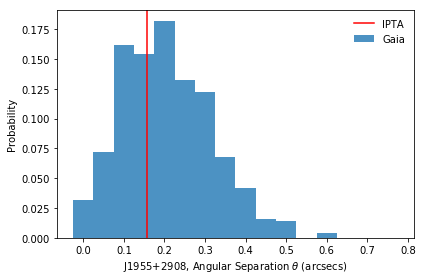

In [229]:
bin_list = auto_bin(.05,0.0,0.8)
weights = hist_weight(seps)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(seps, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(gaia_ipta_sep, color='red', label = "IPTA")
plt.xlabel(r"J1955+2908, Angular Separation $\theta$ (arcsecs)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1955_Theta_IPTA-GAIA.pdf")

In [248]:
bin_list = auto_bin(2e-5,298.865998,298.866200)
weights = hist_weight(gaia_ras)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


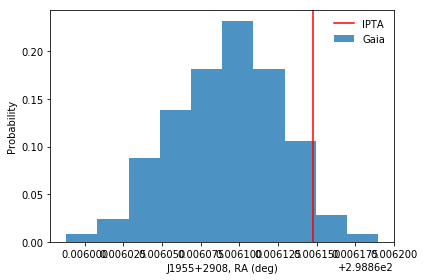

In [249]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(gaia_ras, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_ras), color='red', label = "IPTA")
plt.xlabel("J1955+2908, RA (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1955_RA_IPTA-GAIA.pdf")




In [250]:
min(gaia_decs)

29.145236817846868

In [251]:
max(gaia_decs)

29.14551175996111

In [252]:
bin_list = auto_bin(2e-5,29.145236817846868,29.14551175996111)
weights = hist_weight(gaia_decs)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


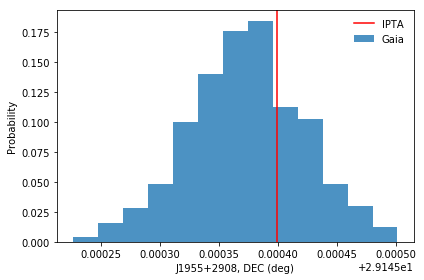

In [254]:
# DEC plot for J1732
plt.hist(gaia_decs, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_decs), color='red', label = "IPTA")
ax.set_xlim([np.min(ipta_decs),np.max(ipta_decs)])
plt.xlabel("J1955+2908, DEC (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1955_DEC_IPTA-GAIA.pdf")

(array([ 10.,  19.,  70.,  87., 143.,  76.,  63.,  26.,   4.,   2.]),
 array([29.14539646, 29.14539707, 29.14539768, 29.14539829, 29.14539891,
        29.14539952, 29.14540013, 29.14540074, 29.14540135, 29.14540197,
        29.14540258]),
 <a list of 10 Patch objects>)

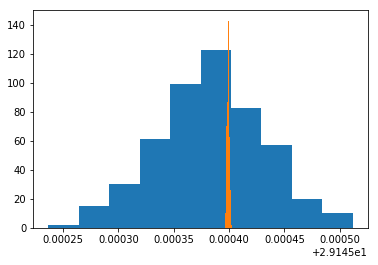

In [257]:
plt.hist(gaia_decs)
plt.hist(ipta_decs)
